In [1]:
#!python -m pip install nidaqmx
import threading
import random
import time
from queue import Queue, Empty
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nidaqmx
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import AcquisitionType 
from nidaqmx.stream_readers import AnalogMultiChannelReader,AnalogSingleChannelReader
import os
from IPython.display import clear_output

In [2]:
class Plater:
    def __init__(self,samplesPerSecond):
        self.samplesPerSec=samplesPerSecond
        
        self.channelMap = {}
        self.channels=[]
        
        logicMap ={}
        
        for i in range(0,16):
            res = [int(i)==1 for i in list('{0:04b}'.format(i))]
            logicMap[i] =res[::-1]
            
        cc=0
        for chan in ['N','W']:
            for index in range(8,1,-1):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        for chan in ['E','S']:
            for index in range(1,9):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        self.start()
        
    def start(self):
        self.iMonTask = nidaqmx.Task(new_task_name ='iMonTask')
        self.muxTask = nidaqmx.Task(new_task_name ='muxTask')
        self.topBottomTask = nidaqmx.Task(new_task_name ='topBottomTask')
        self.resetTask = nidaqmx.Task(new_task_name ='resetTask')
        self.controlTask = nidaqmx.Task(new_task_name ='controlTask')
        self.biasTask = nidaqmx.Task(new_task_name ='biasTask')
        self.icutTask  = nidaqmx.Task(new_task_name ='icutTask')
        self.muxTask.do_channels.add_do_chan("Dev1/port0/line2:7", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.topBottomTask.do_channels.add_do_chan("Dev1/port0/line1", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.resetTask.do_channels.add_do_chan("Dev1/port0/line0", line_grouping=LineGrouping.CHAN_PER_LINE)
    
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
        self.iMonTask.timing.cfg_samp_clk_timing(self.samplesPerSec, source="", sample_mode=AcquisitionType.CONTINUOUS, samps_per_chan=self.samplesPerSec)
        self.iMonReader = AnalogSingleChannelReader(self.iMonTask.in_stream)
    
        self.biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
        self.icutTask.ao_channels.add_ao_voltage_chan("Dev1/ao1")
         
        self.setBias(0)
        self.setThreshold(10)
        
    def __enter__(self):
        return self 
 
    def __exit__(self, *args):
        print('Closing tasks')
        self.setBias(0)
        self.setThreshold(0)
        self.iMonTask.close()
        self.muxTask.close()
        self.topBottomTask.close()
        self.resetTask.close()
        self.controlTask.close()
        self.biasTask.close()
        self.icutTask.close()

    def ResetDevice(self ):
        self.resetTask.write([True ], auto_start=True)
        time.sleep(.1)
        self.resetTask.write([False ], auto_start=True)

    def TopElectrode(self ):
        self.topBottomTask.write([True ], auto_start=True)
        time.sleep(.1)

    def BottomElectrode(self ):
        self.topBottomTask.write([False ], auto_start=True)
        time.sleep(.1)    

    def SelectChannel(self,channel ):
        self.muxTask.write(self.channelMap[channel], auto_start=True)
        time.sleep(.1)

    def setBias(self,bias ):
        self.biasTask.write([bias], auto_start=True)

    def pulseBias(self,bias, pulseLengthS,totalLengthS ):
        mid = int((totalLengthS-pulseLengthS)/2*samplesPerSec)
        points = int(pulseLengthS*samplesPerSec)
        outs=[0]*(int(samplesPerSec*totalLengthS))
        for i in range(mid,mid+points):
            outs[i]=bias
        self.biasTask.write(outs, auto_start=True)

    def setThreshold(self,current_nA ):
        bias = current_nA/50.0
        print('Thresh Current:' + str(current_nA) + 'nA', 'bias:' + str(bias) + 'V')
        self.icutTask.write([bias], auto_start=True)
        
    def runPulseTrain(self,bias, pulseLengthS,totalLengthS):
        mid = int((totalLengthS-pulseLengthS)/2*samplesPerSec)
        points = int(pulseLengthS*samplesPerSec)
        outs=[0]*(int(samplesPerSec*totalLengthS))
        for i in range(mid,mid+points):
            outs[i]=bias
        self.biasTask.write(outs, auto_start=True)
        
    def disableThreshold(self):
        self.resetTask.write([True ], auto_start=True)
        
    def runConstantBias(self,bias_V, threshold_nA, maxTimeS,delayTimeS=1,resetToZero=True,samplesPerPoint=200):
        
         
        output = np.zeros([ samplesPerPoint])
        currents=[]
        times =[]
        starts = time.time()
        slew_V_s=1000/1000
        secPerSample=1.0/self.samplesPerSec*samplesPerPoint
        segmentTime = bias_V/slew_V_s
        segmentPoints =int( segmentTime/secPerSample)
        biasi =   np.linspace(0,bias_V,segmentPoints) 
        self.iMonTask.start()
        maxA=0
        self.setThreshold(current_nA = 50)
        for bias in biasi:
            self.setBias(bias)
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setBias(bias_V)
        startDelay = time.time()
        while (time.time()- startDelay)<delayTimeS:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setThreshold(current_nA = threshold_nA)
        while (time.time()- starts)<maxTimeS and maxA<threshold_nA:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.iMonTask.stop()
        if resetToZero:
            self.setBias(0)
        currents=np.array(currents)
        clear_output(wait=True)
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.plot(times,currents, color=color)
        ax1.set_ylabel('Current (nA)', color=color)
        ax1.set_xlabel('Time (S)')
        fig.tight_layout() 
        plt.show()
        return maxA>threshold_nA,times,currents
    
    def runIV(self, maxVoltage, slew_mV_s,samplesPerPoint=200):
        slew_V_s=slew_mV_s/1000
        secPerSample=1.0/self.samplesPerSec*samplesPerPoint
        segmentTime = maxVoltage/slew_V_s
        segmentPoints =int( segmentTime/secPerSample)
        biasi = np.concatenate( [np.linspace(0,maxVoltage,segmentPoints),np.linspace(maxVoltage,0,segmentPoints),
                               np.linspace(0,-1*maxVoltage,segmentPoints),np.linspace(-1*maxVoltage,0,segmentPoints)])
        
        output = np.zeros([ samplesPerPoint])
        currents=[]
        outBias=[]
        self.iMonTask.start()
        
        times =[]
        starts = time.time()
        for bias in biasi:
            self.setBias(bias)
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            times.append( time.time()- starts)
            currents.append(np.mean(output))
            outBias.append(bias)
        self.iMonTask.stop()
        currents=np.array(currents)*50
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.plot(times,currents, color=color)
        ax1.set_ylabel('Current (nA)', color=color)
        ax1.set_xlabel('Time (S)')
        
        ax2 = ax1.twinx() 
        color = 'tab:blue'
        ax2.set_ylabel('Bias (V)', color=color)  # we already handled the x-label with ax1
        ax2.plot(times,outBias, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout() 
        plt.show()
        
        slope=1/np.polyfit(outBias,currents,1)[0]*1000
        print(str(slope), 'MOhms')
        
        return slope, outBias,currents
        

In [ ]:
wafer='P008'
chip ='C3'
stage ='Plate'
bothElectrodes=True
threshold_nA=5
shortedThreshold_MOHM=3

if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
    os.mkdir(f'C:/Data/Plater/{wafer}')
if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
    os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')
    
channel='N8'    
filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
if os.path.exists(filename + '_initialIV.npy'):
    #raise Exception('Wrong Path')    
    pass

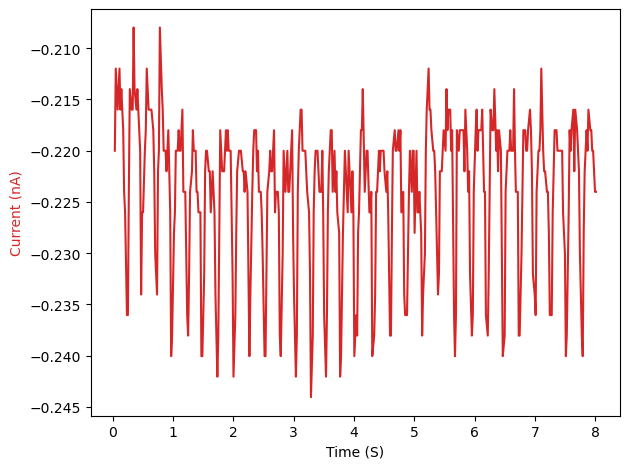

Thresh Current:50nA bias:1.0V
Closing tasks
Thresh Current:0nA bias:0.0V


KeyboardInterrupt: 

In [192]:
#########################################  Plating loop ##################################
with Plater(10000) as plater:
    for channel in plater.channels:
        print(channel)
        plater.setBias(0)
        plater.TopElectrode()
        plater.setThreshold(current_nA = 200)
        plater.disableThreshold()
        slope, outBias,currents =plater.runIV(maxVoltage=.1,slew_mV_s=1000)

        with open(filename + '_BeforeIV.npy', 'wb') as f:
            np.save(f, slope)
            np.save(f, outBias)
            np.save(f, currents)

        if slope<shortedThreshold_MOHM:
            print('Shorted' + channel)   
            continue

        time.sleep(1)
        plater.ResetDevice()
        plater.BottomElectrode()

        times=[]
        currents=[]
        for i in range(60):

            if i%2==0 and bothElectrodes:
                plater.TopElectrode()
            else:
                plater.BottomElectrode()
            passed,xTime,curr=plater.runConstantBias(bias_V=1, threshold_nA=threshold_nA, maxTimeS=8)
            if len(times)==0 :
                times=xTime
                currents=curr
            else:
                times=np.concatenate([times,xTime+times[-1]])
                currents=np.concatenate([currents,curr])

            if passed:
                break


        with open(filename + '_plate.npy', 'wb') as f:
            np.save(f, times)
            np.save(f, currents)


        plater.setBias(0)
        plater.TopElectrode()
        plater.setThreshold(current_nA = 200)
        plater.disableThreshold()
        slope, outBias,currents =plater.runIV(maxVoltage=.1,slew_mV_s=1000)

        with open(filename + '_IV.npy', 'wb') as f:
            np.save(f, slope)
            np.save(f, outBias)
            np.save(f, currents)

        plater.setBias(0)

Thresh Current:10nA bias:0.2V
Thresh Current:200nA bias:4.0V
N8


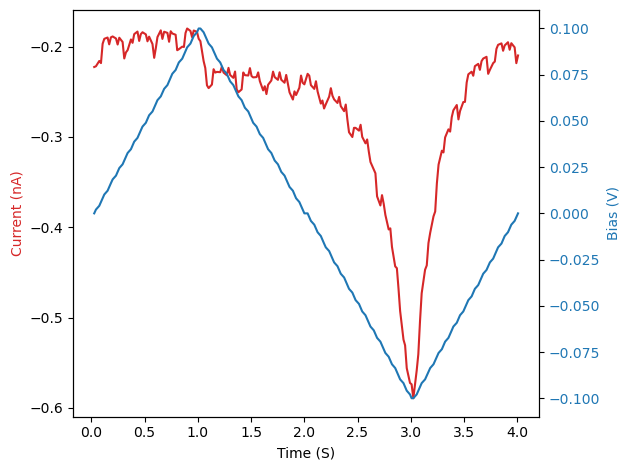

863.5521172683625 MOhms
N7


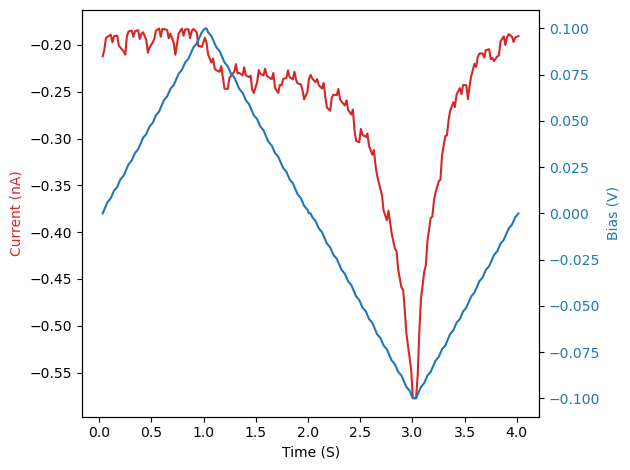

924.1104947964982 MOhms
N6


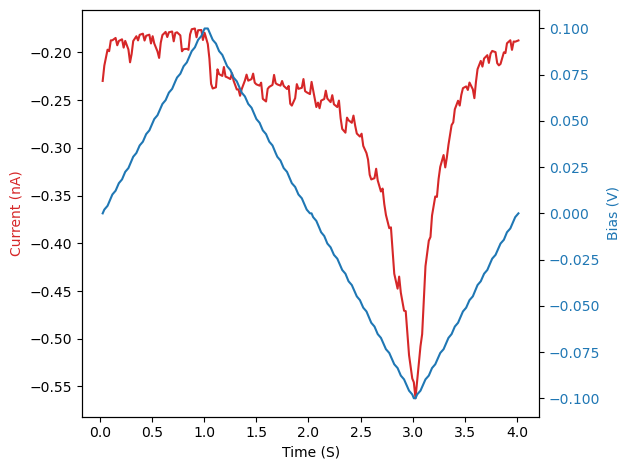

912.551669096042 MOhms
N5


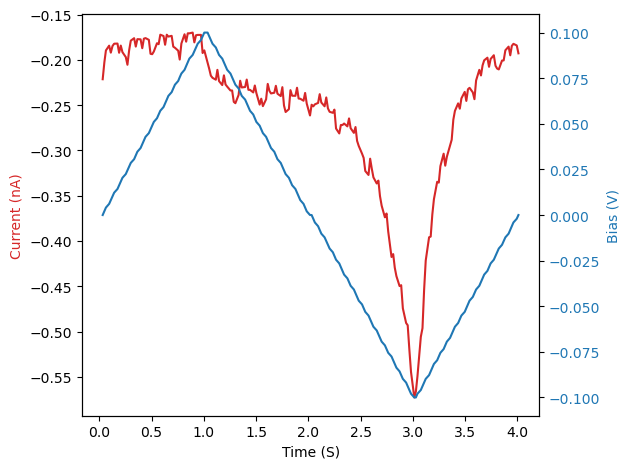

885.5325337956837 MOhms
N4


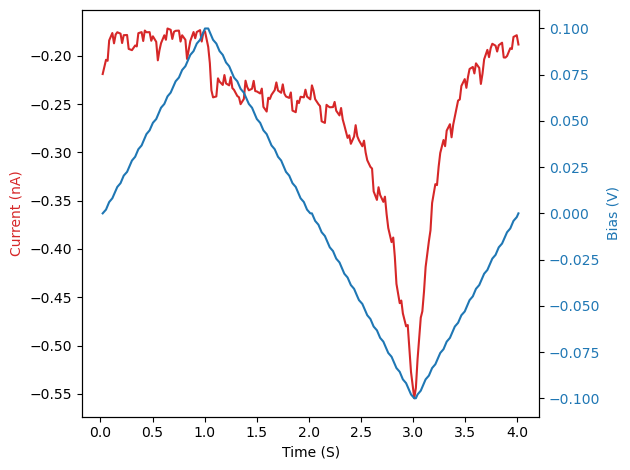

968.0068504213475 MOhms
N3


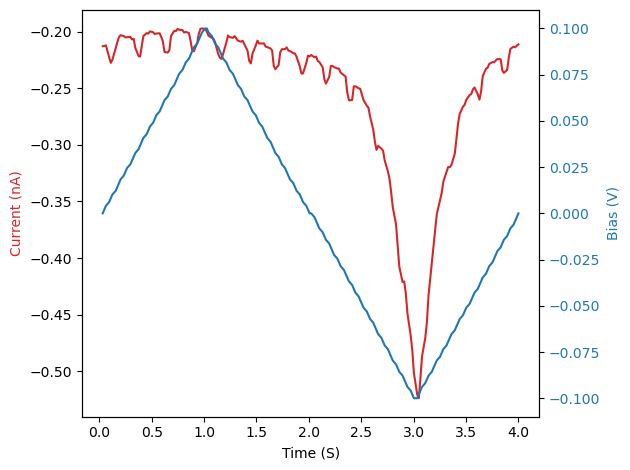

1003.2627209337617 MOhms
N2


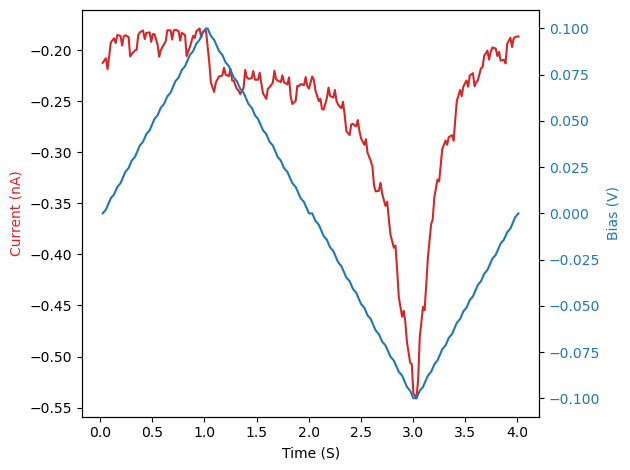

980.5299781058601 MOhms
W8


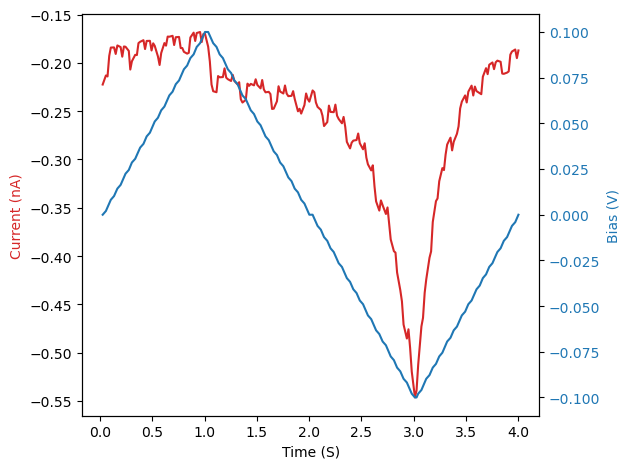

917.1291220602071 MOhms
W7


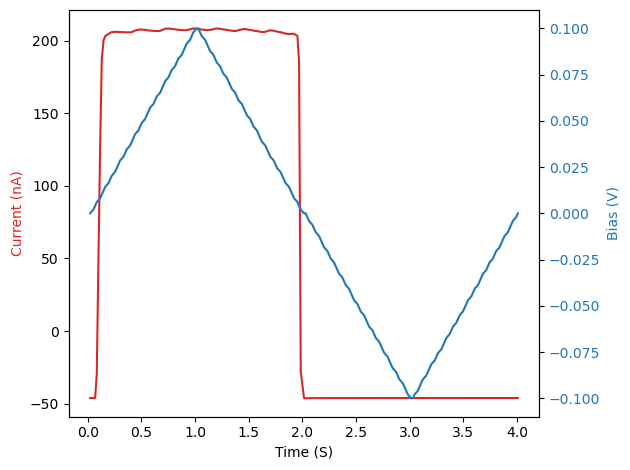

0.5335864013466016 MOhms
W6


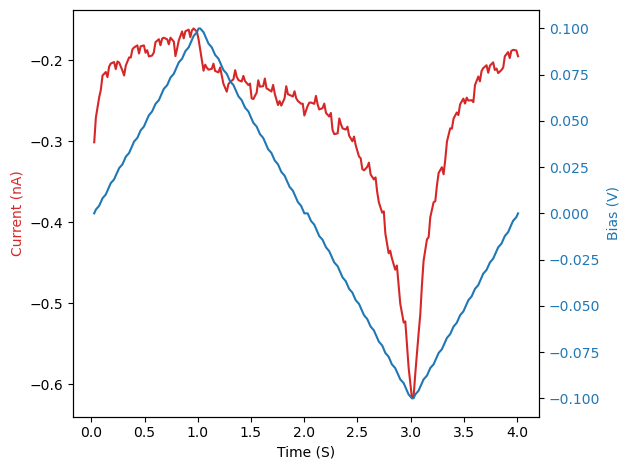

771.4432270240412 MOhms
W5


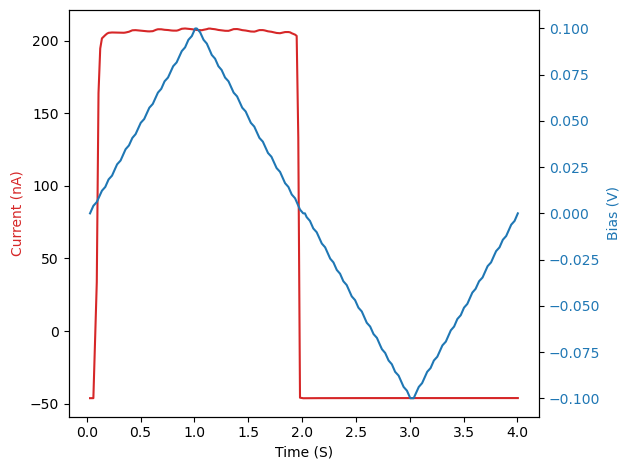

0.5333628179954929 MOhms
W4


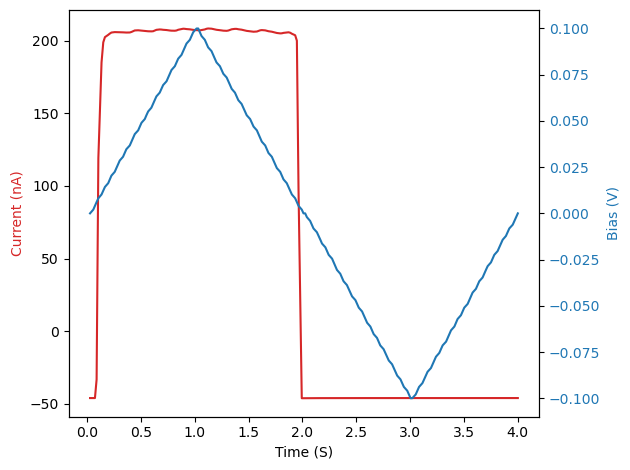

0.5337932856574183 MOhms
W3


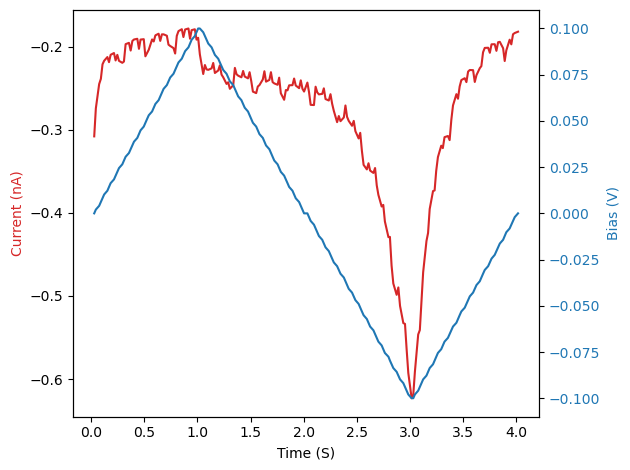

811.7676812198908 MOhms
W2


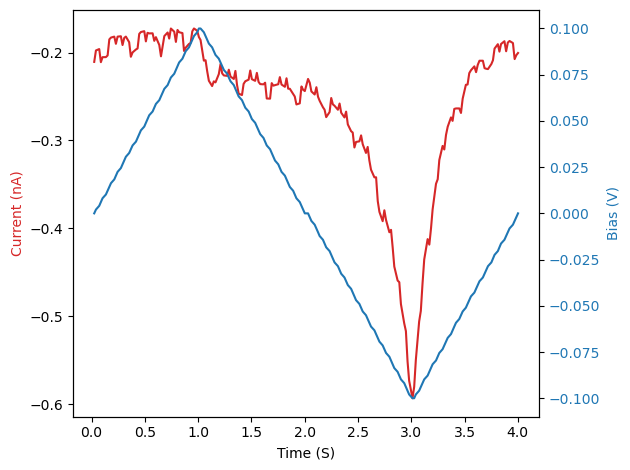

854.6339905240311 MOhms
E1


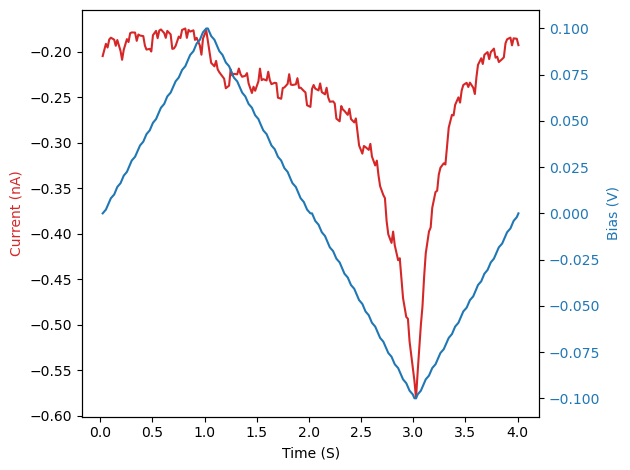

896.3530279076497 MOhms
E2


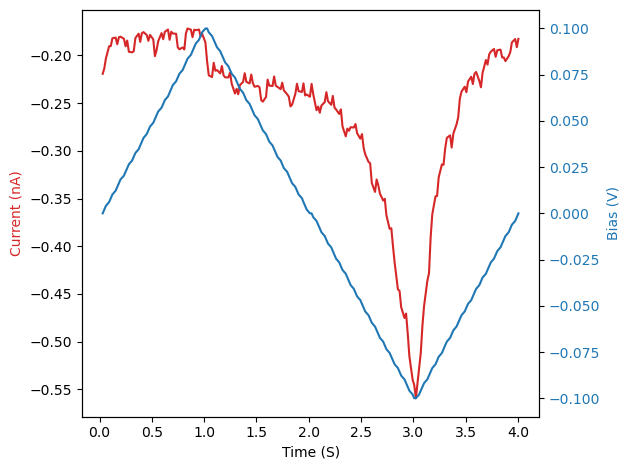

897.2079635011082 MOhms
E3


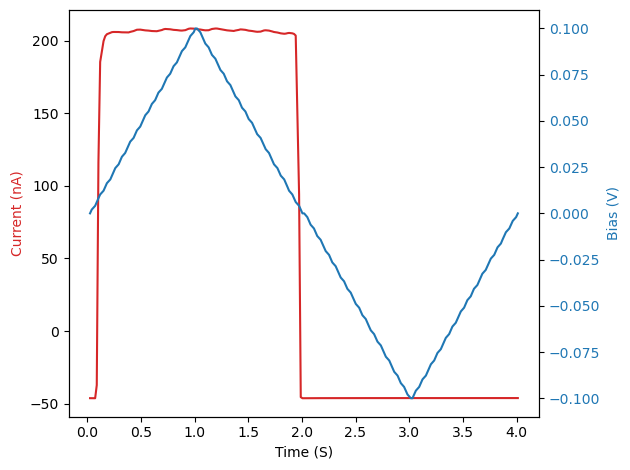

0.5338215133507084 MOhms
E4


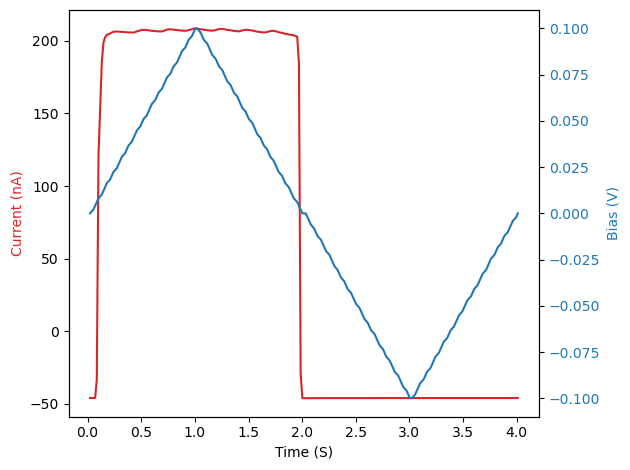

0.5336147975557616 MOhms
E5


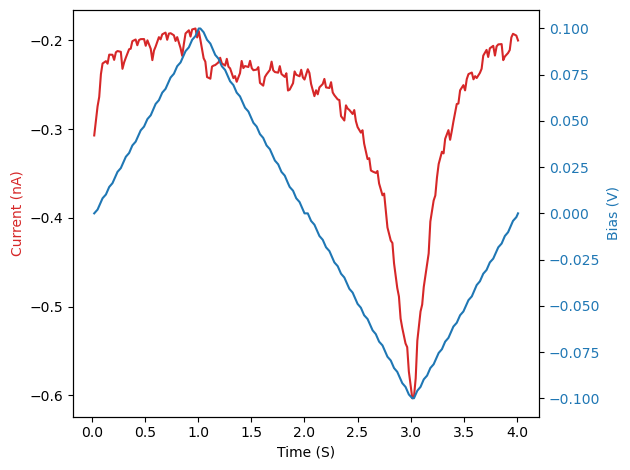

844.9003482607864 MOhms
E6


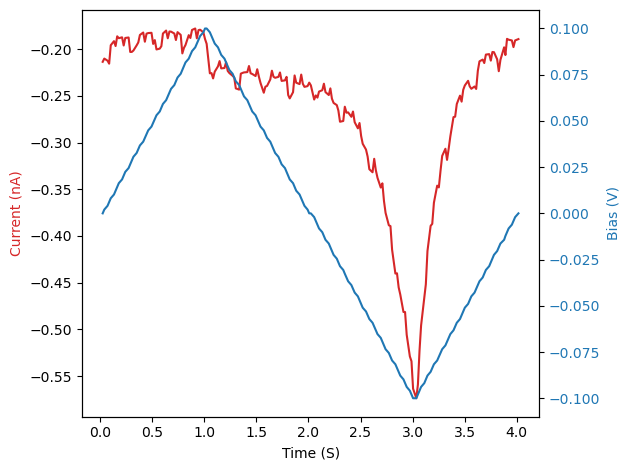

877.9484063658007 MOhms
E7


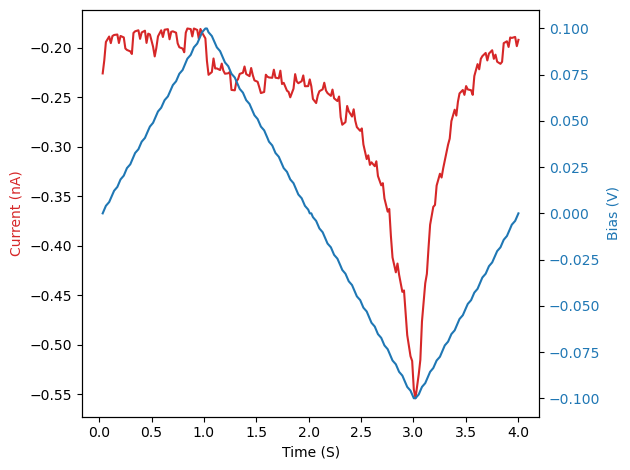

949.6998107946182 MOhms
E8


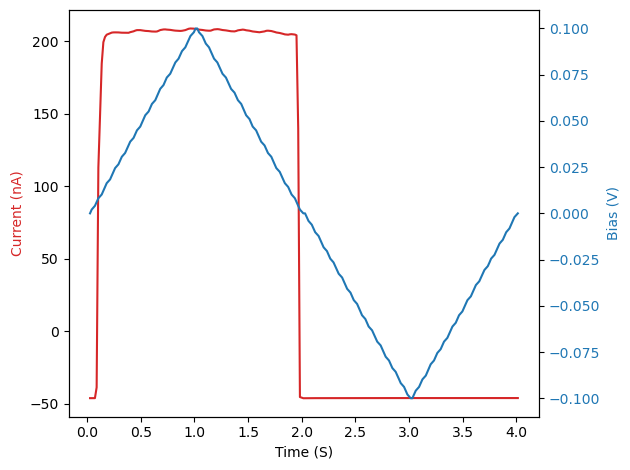

0.5337771450824677 MOhms
S1


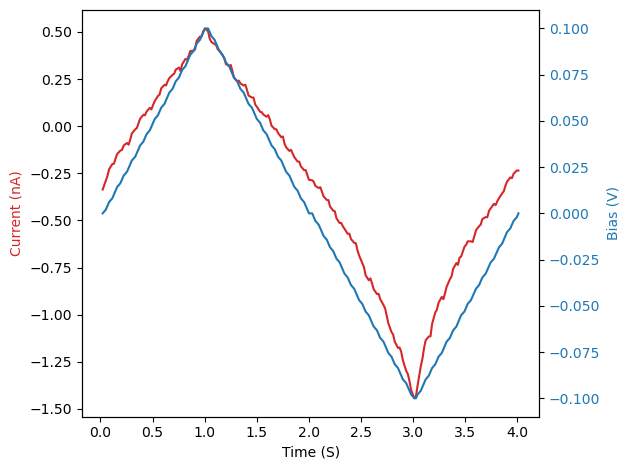

115.41068028547011 MOhms
S2


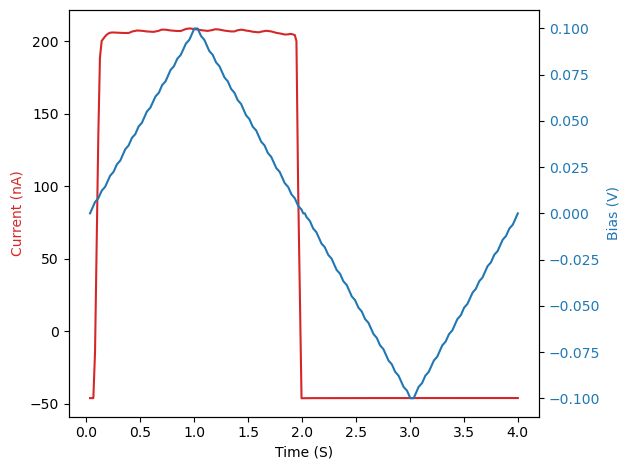

0.5336781157149605 MOhms
S3


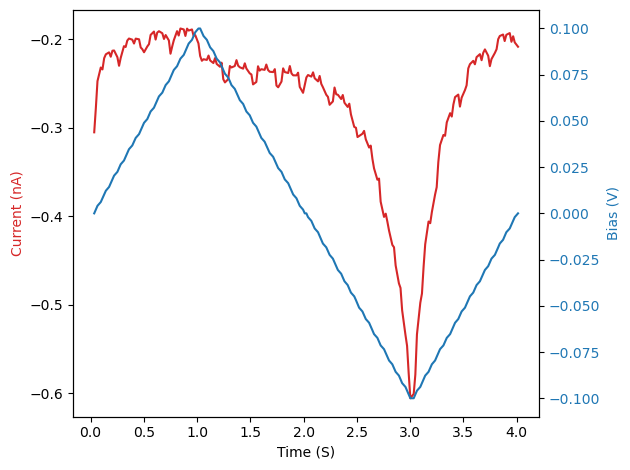

872.4147575782441 MOhms
S4


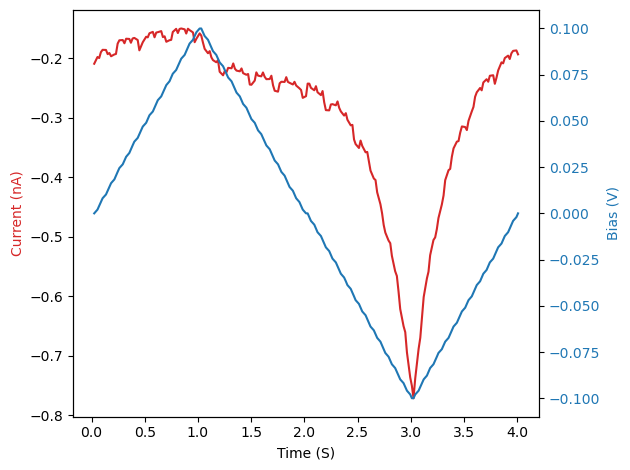

495.5766157595792 MOhms
S5


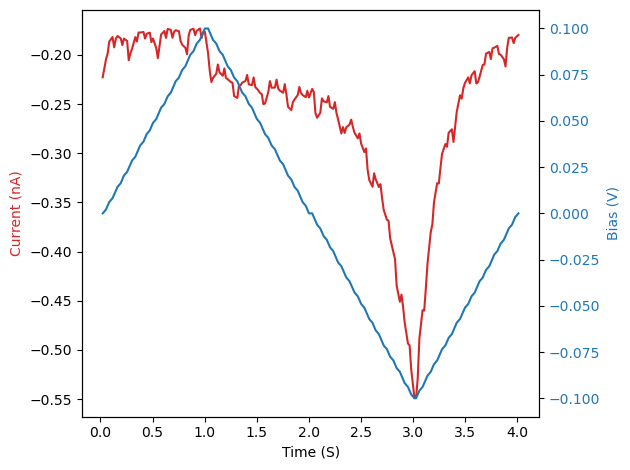

930.0235794527408 MOhms
S6


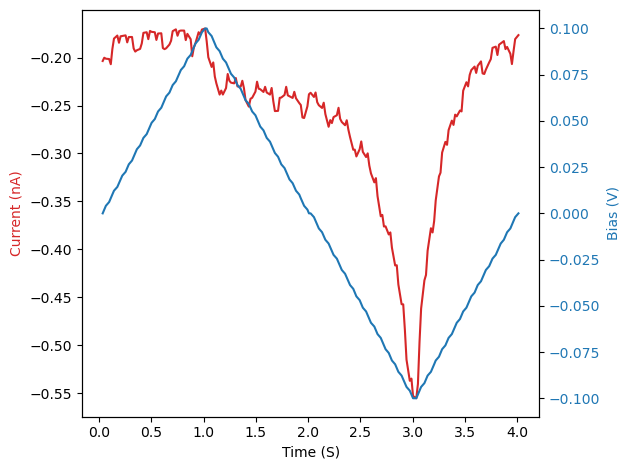

907.2743337708733 MOhms
S7


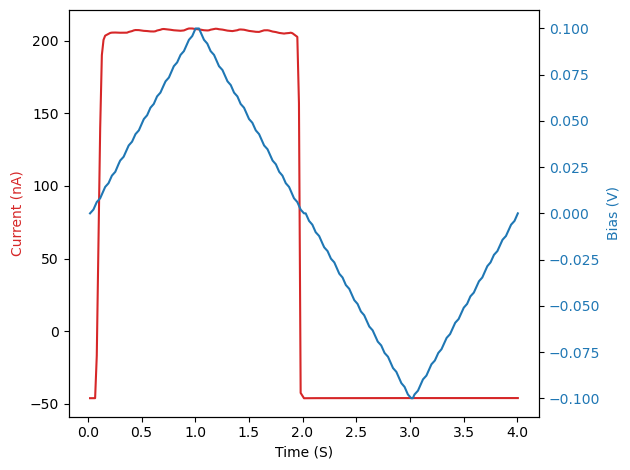

0.5335360736537895 MOhms
S8


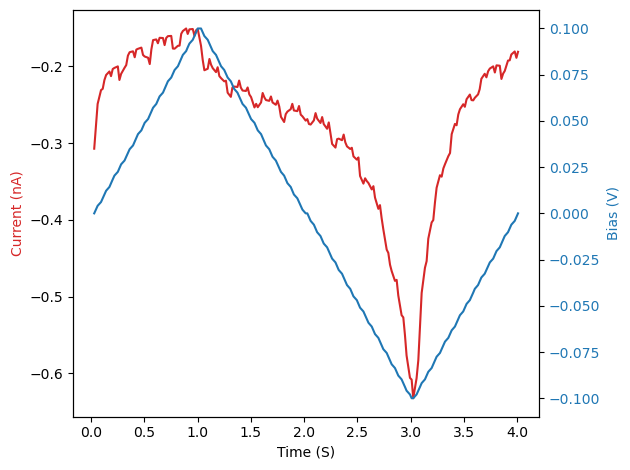

698.2339339144277 MOhms
Closing tasks
Thresh Current:0nA bias:0.0V


In [18]:
#########################################  Perform just the IV ##################################
stage ='Rehydrate_reordered'

if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
    os.mkdir(f'C:/Data/Plater/{wafer}')
if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
    os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')

channel='N8'    
filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
if os.path.exists(filename + '.npy'):
    raise Exception('Wrong Path')    
    pass

with Plater(10000) as plater:
        plater.setBias(0)
        plater.TopElectrode()
        
        plater.setThreshold(current_nA = 200)
        plater.disableThreshold()

        for channel in plater.channels:
            print(channel)
            plater.SelectChannel(channel)
            slope, outBias,currents =plater.runIV(maxVoltage=.1,slew_mV_s=100)
            plater.setBias(0)
            
            filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
            with open(filename, 'wb') as f:
                np.save(f, slope)
                np.save(f, outBias)
                np.save(f, currents)
            

BSA


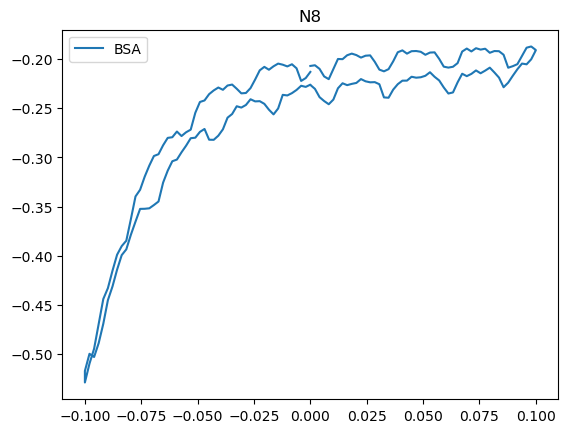

BSA


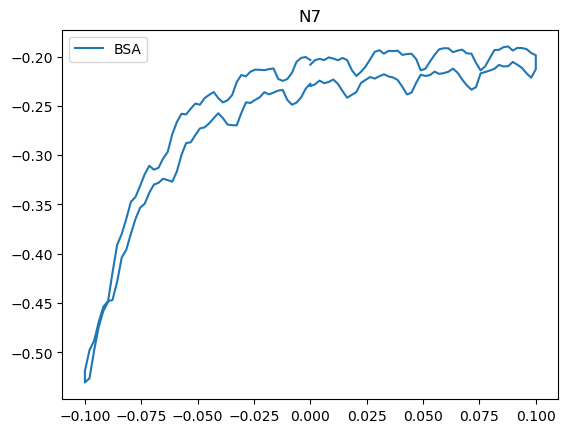

BSA


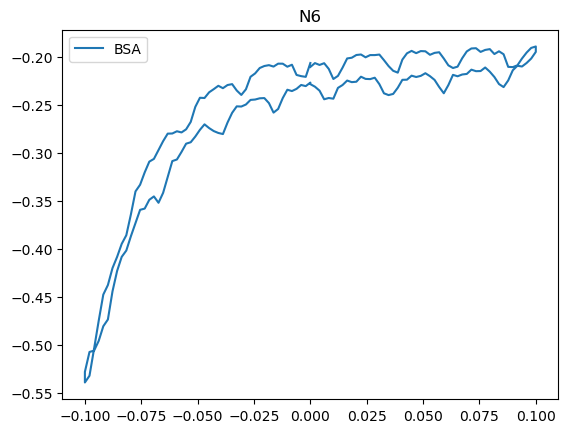

BSA


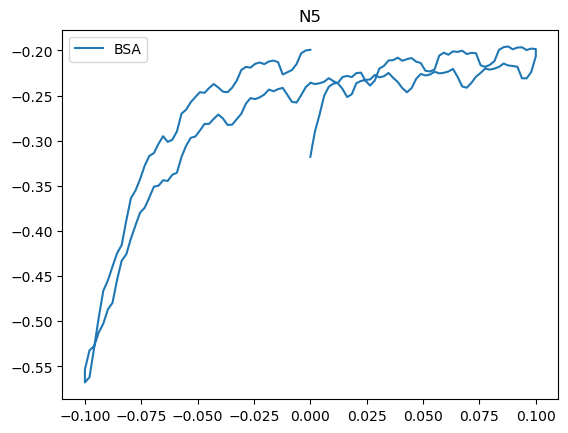

BSA


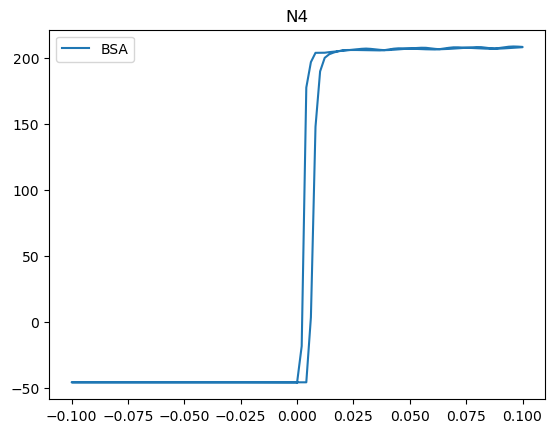

BSA


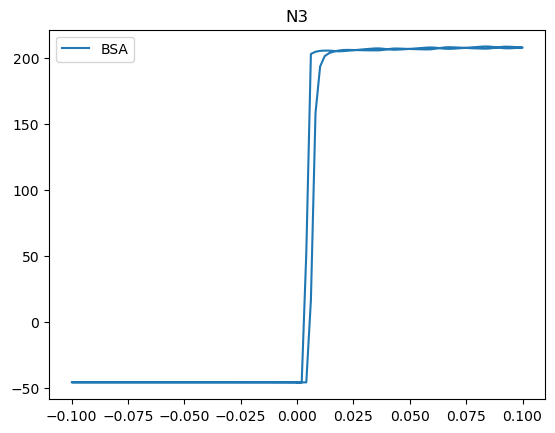

BSA


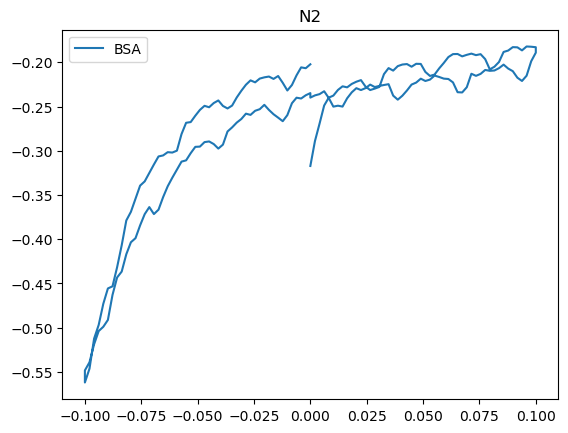

BSA
HEPES


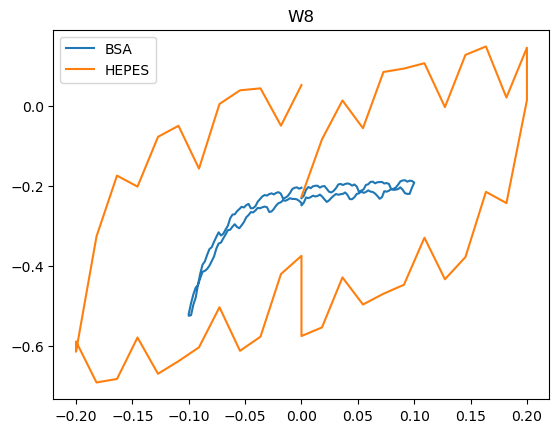

BSA
HEPES


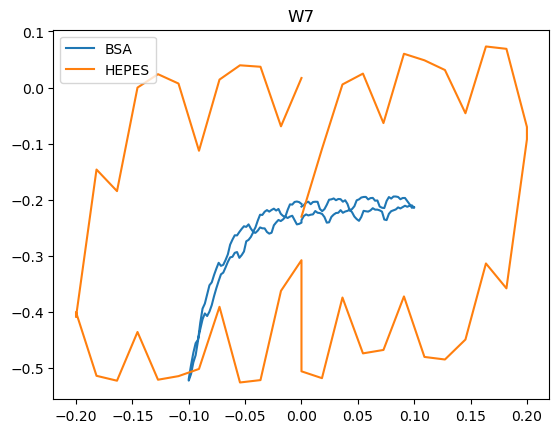

BSA
HEPES


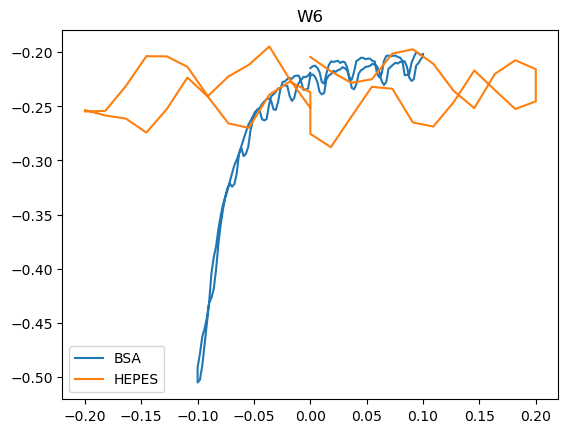

BSA
HEPES


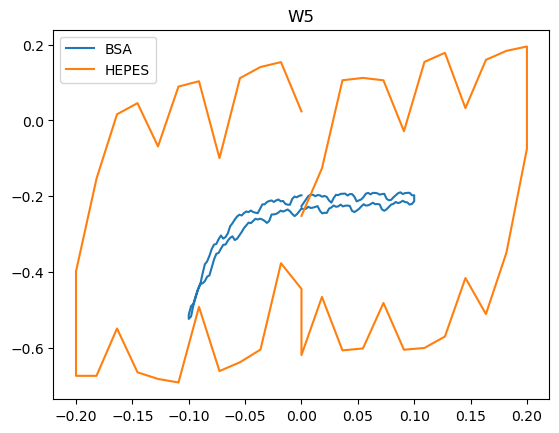

BSA
HEPES


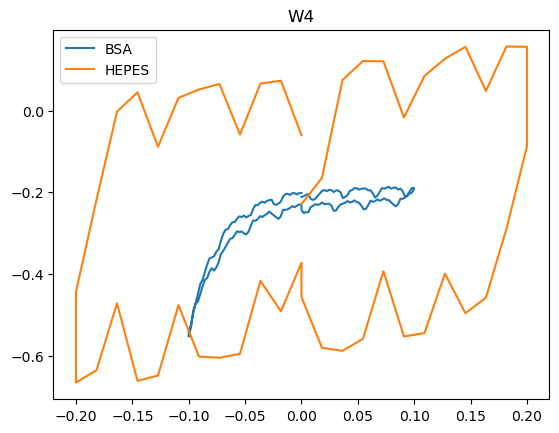

BSA
HEPES


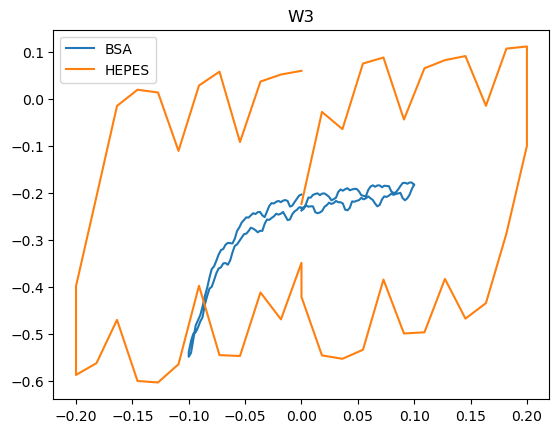

BSA
HEPES


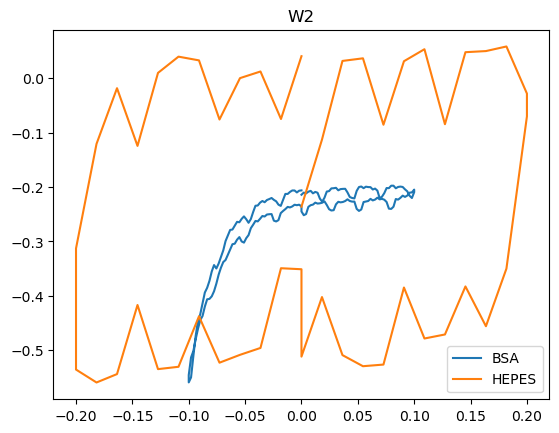

BSA
HEPES


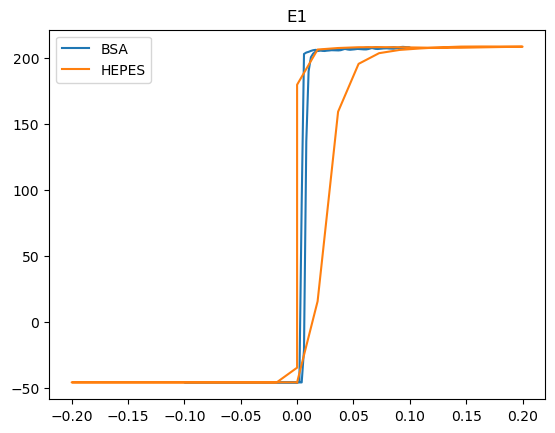

BSA
HEPES


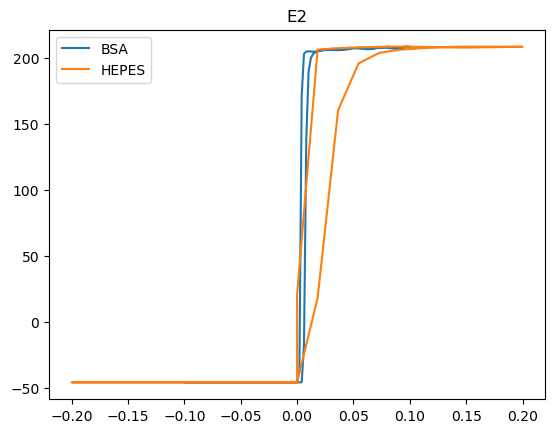

BSA
HEPES


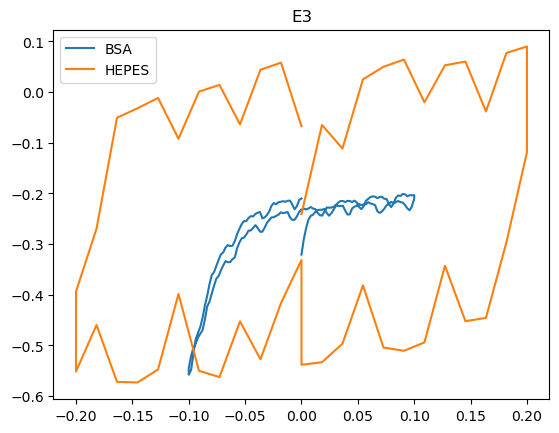

BSA
HEPES


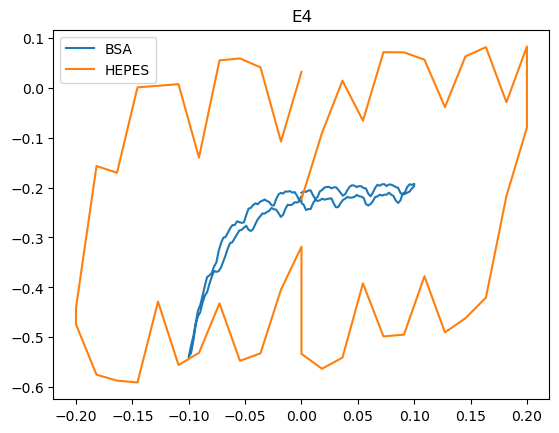

BSA
HEPES


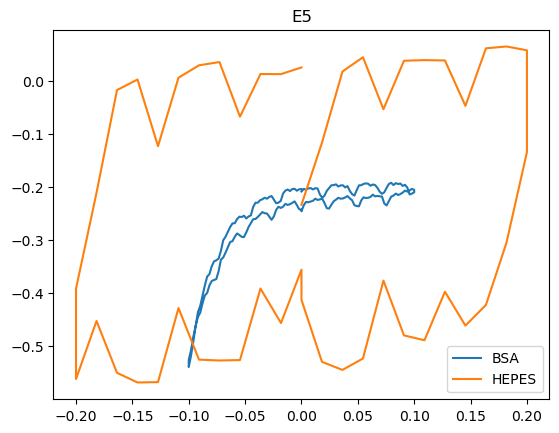

BSA
HEPES


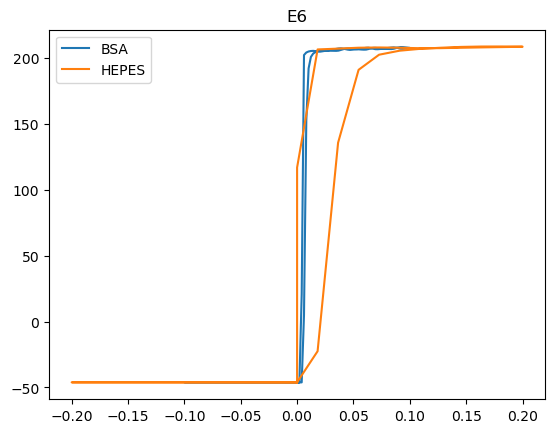

BSA
HEPES


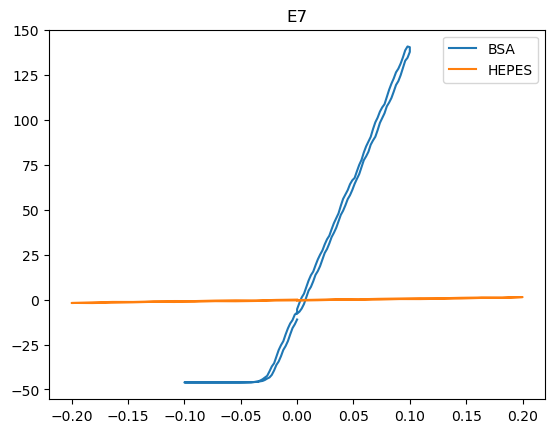

BSA
HEPES


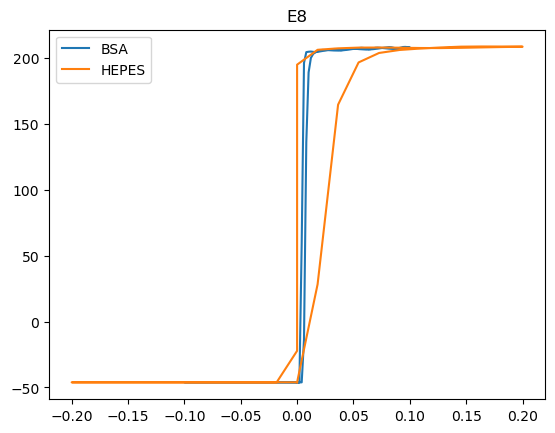

BSA
HEPES


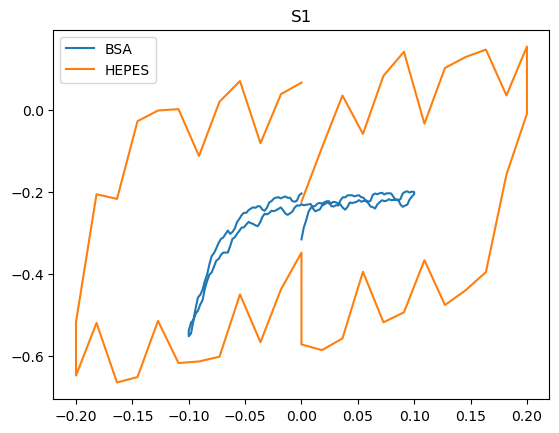

BSA
HEPES


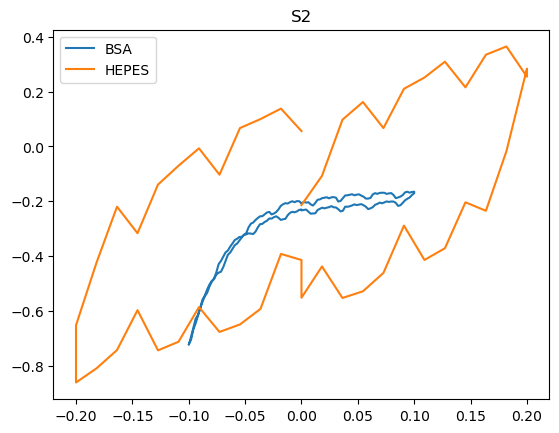

BSA
HEPES
HEPES3
HEPES3


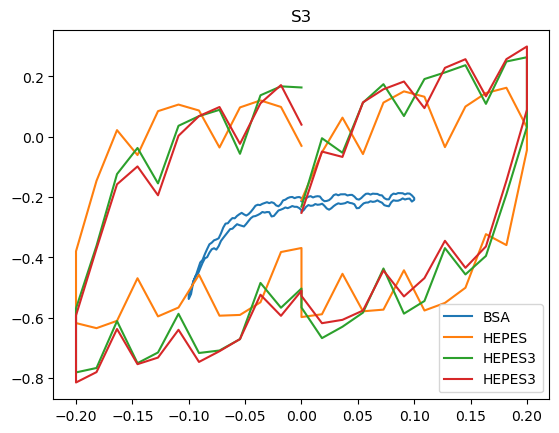

BSA
HEPES


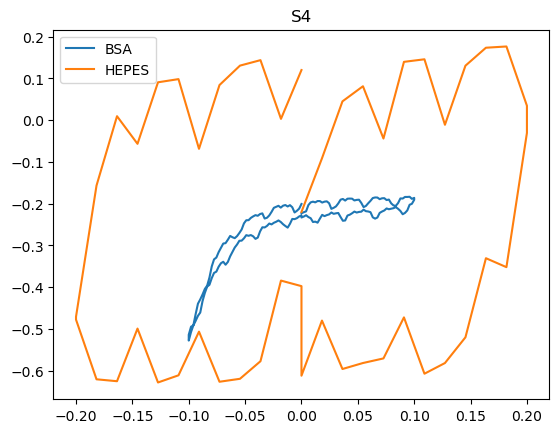

BSA
HEPES3
HEPES


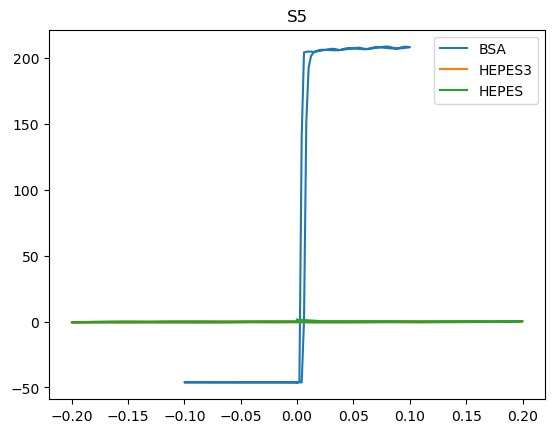

BSA
HEPES3


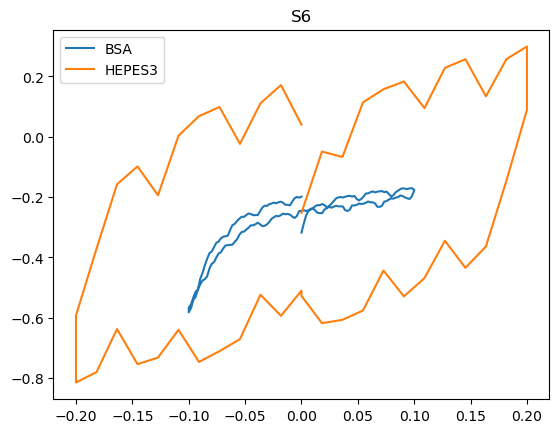

BSA


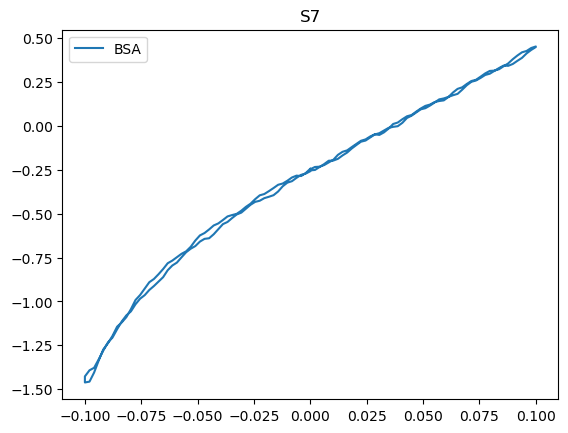

BSA


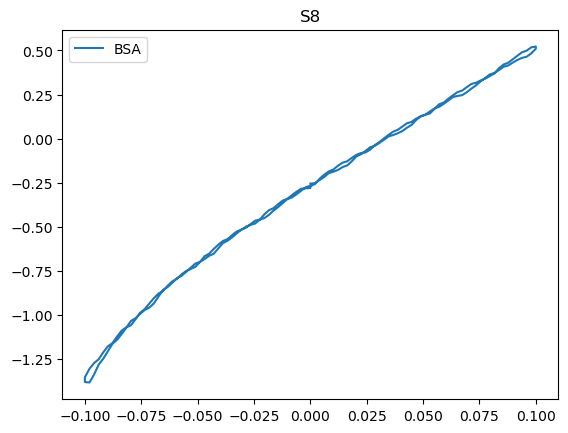

In [32]:
folder= f'C:/Data/Plater/{wafer}/{chip}'
files = os.listdir( folder  )
for channel in plater.channels:
    cFiles = [file for file in files if channel in file and ('HEPES_' in file or 'HEPES3_' in file or 'BSA_Dry' in file)]
    for file in cFiles:
        label="_".join(file.split('_')[1:-1])
        print(label)
        with open(folder+'/'+file, 'rb') as f:
            slope=np.load(f)
            outBias=np.load(f)
            current=np.load(f)
        plt.plot(outBias,current,label=label)
    plt.title(channel)
    plt.legend()   
    plt.show()
    
    

In [19]:
os.getcwd()

'C:\\Users\\bashc'